## Data Set Preparation

In [2]:
import os
import cv2
from PIL import Image

def resize_and_preserve_aspect_ratio(image_path, target_size, output_path):
    # Resize an image to the target size while preserving aspect ratio.
    try:
        img = cv2.imread(image_path)  # Read the image in color mode (default BGR)
        if img is None:
            print(f"Error: Unable to read {image_path}")
            return

        # Get original dimensions
        original_height, original_width = img.shape[:2]
        target_width, target_height = target_size

        # Calculate the scaling factors
        scale_width = target_width / original_width
        scale_height = target_height / original_height
        scale = min(scale_width, scale_height)

        # Compute the new dimensions
        new_width = int(original_width * scale)
        new_height = int(original_height * scale)

        # Resize the image
        resized_img = cv2.resize(
            img, (new_width, new_height),
            interpolation=cv2.INTER_CUBIC if scale > 1 else cv2.INTER_AREA
        )

        # Add padding to achieve the exact target size
        delta_w = target_width - new_width
        delta_h = target_height - new_height
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        padded_img = cv2.copyMakeBorder(
            resized_img, top, bottom, left, right,
            cv2.BORDER_CONSTANT, value=[0, 0, 0]  # Black padding
        )

        # Convert BGR to RGB
        rgb_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)

        # Save the image using Pillow (PIL)
        pil_img = Image.fromarray(rgb_img)  # Convert to PIL Image
        pil_img.save(output_path)  # Save the image

        print(f"Resized and saved: {output_path}")

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

def resize_images_in_folder(input_folder, output_folder, target_size):
    # Resize all images in the input folder and save them to the output folder.
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            input_path = os.path.join(root, file)
            output_path = os.path.join(output_folder, file)
            resize_and_preserve_aspect_ratio(input_path, target_size, output_path)

if __name__ == "__main__":
    # Define input and output folders
    input_happy = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\happy"
    input_sad = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\sad"
    output_happy = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy"
    output_sad = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_sad"

    # Define target size
    target_size = (128, 128)  # Change to your desired resolution

    print("\nResizing Happy images...")
    resize_images_in_folder(input_happy, output_happy, target_size)

    print("\nResizing Sad images...")
    resize_images_in_folder(input_sad, output_sad, target_size)

    print("\nResizing process completed.")



Resizing Happy images...
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\-41604787097oijary3e0b.png
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\-cheerful-african-american-black-male-happy-expressive-smiley-face-197149245.jpg
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\05-12-21-happy-people.jpg
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\1000_F_185048528_i9zX0FC3Q8iDNb2E5hanWzN0KeJSXSy6.jpg
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\1000_F_206825373_PfhE4TyHbpUXggBKdTLZYn0HcuRCP9rf.jpg
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\1000_F_246149544_RZIU2J7fQKl9JVWZBeSvJHUCRtdjTqAl.jpg
Resized and saved: C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy\1000_F_254262588_wbdwGWgnETRzXZo49JBRLfkjnUybShBE.jpg
Resized and saved: C:\

## Checking if the dataset is balanced

In [3]:
import os

def count_images(folder):
    """Count the number of images in a folder."""
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Define folder paths
happy_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy"
sad_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_sad"

# Count images in each folder
happy_count = count_images(happy_folder)
sad_count = count_images(sad_folder)

print(f"Number of Happy images: {happy_count}")
print(f"Number of Sad images: {sad_count}")

# Check if the dataset is balanced
if happy_count != sad_count:
    print("Warning: The dataset is imbalanced!")
    if happy_count > sad_count:
        print(f"The Happy class has {happy_count - sad_count} more images than the Sad class.")
    else:
        print(f"The Sad class has {sad_count - happy_count} more images than the Happy class.")
else:
    print("The dataset is balanced.")


Number of Happy images: 589
Number of Sad images: 491
The Happy class has 98 more images than the Sad class.


## Balancing the Dataset 
    Will do Undersample for the "Happy" class

In [21]:
import os
import random
import shutil

def undersample_images(input_folder, output_folder, target_count):
    """
    Reduce the number of images in the input folder to the target count.
    Parameters:
        input_folder (str): Path to the folder containing the original images.
        output_folder (str): Path to the folder where undersampled images will be saved.
        target_count (int): The desired total number of images.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Get all files in the input folder
    files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    current_count = len(files)
    print(f"Current number of images: {current_count}")

    if current_count <= target_count:
        print("The number of images is already less than or equal to the target count. No undersampling needed.")
        for file in files:
            src_path = os.path.join(input_folder, file)
            dest_path = os.path.join(output_folder, file)
            shutil.copy2(src_path, dest_path)
        return

    # Randomly select files to keep
    selected_files = random.sample(files, target_count)

    # Move the selected files to the output folder
    for file in selected_files:
        src_path = os.path.join(input_folder, file)
        dest_path = os.path.join(output_folder, file)
        shutil.copy2(src_path, dest_path)

    print(f"Undersampled {len(selected_files)} images to {output_folder}.")

# Define paths
happy_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_happy"
undersampled_happy_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\undersampled_happy"
sad_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_sad"

# Target count
sad_count = len([f for f in os.listdir(sad_folder) if os.path.isfile(os.path.join(sad_folder, f))])
print(f"Number of Sad images: {sad_count}")

# Perform undersampling
undersample_images(happy_folder, undersampled_happy_folder, sad_count)


Number of Sad images: 491
Current number of images: 589
Undersampled 491 images to C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\undersampled_happy.


## Verifying Counts after decreasing "Happy"

In [22]:
import os

def count_images(folder):
    """
    Count the number of images in a folder.
    """
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# Define paths
undersampled_happy_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\undersampled_happy"
sad_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_sad"

# Count images
happy_count = count_images(undersampled_happy_folder)
sad_count = count_images(sad_folder)

# Print results
print(f"Number of Happy images (undersampled): {happy_count}")
print(f"Number of Sad images: {sad_count}")


Number of Happy images (undersampled): 491
Number of Sad images: 491


## Splitting Dataset

In [25]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_data(happy_folder, sad_folder, output_folder, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split "Happy" and "Sad" images into train, validation, and test sets, and organize into a single folder structure.
    Parameters:
        happy_folder (str): Path to the "Happy" images folder.
        sad_folder (str): Path to the "Sad" images folder.
        output_folder (str): Path to the output folder where splits will be saved.
        train_ratio (float): Proportion of images for training.
        val_ratio (float): Proportion of images for validation.
        test_ratio (float): Proportion of images for testing.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create combined split folders
    train_folder = os.path.join(output_folder, "train")
    val_folder = os.path.join(output_folder, "val")
    test_folder = os.path.join(output_folder, "test")
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Load and label "Happy" images
    happy_files = [os.path.join(happy_folder, f) for f in os.listdir(happy_folder) if os.path.isfile(os.path.join(happy_folder, f))]
    happy_labels = ["happy"] * len(happy_files)

    # Load and label "Sad" images
    sad_files = [os.path.join(sad_folder, f) for f in os.listdir(sad_folder) if os.path.isfile(os.path.join(sad_folder, f))]
    sad_labels = ["sad"] * len(sad_files)

    # Combine files and labels
    all_files = happy_files + sad_files
    all_labels = happy_labels + sad_labels

    # Split data
    train_files, temp_files, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=(val_ratio + test_ratio), stratify=all_labels, random_state=42)
    val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=temp_labels, random_state=42)

    # Helper to copy files to split folders
    def copy_files(files, labels, target_folder):
        for file, label in zip(files, labels):
            label_folder = os.path.join(target_folder, label)
            os.makedirs(label_folder, exist_ok=True)
            shutil.copy2(file, os.path.join(label_folder, os.path.basename(file)))

    # Copy files to corresponding folders
    copy_files(train_files, train_labels, train_folder)
    copy_files(val_files, val_labels, val_folder)
    copy_files(test_files, test_labels, test_folder)

    print(f"Data split completed: {len(train_files)} training, {len(val_files)} validation, {len(test_files)} testing images.")

# Define paths
happy_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\undersampled_happy"
sad_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data\resized_sad"
output_folder = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split"

# Perform splitting
split_data(happy_folder, sad_folder, output_folder)


Data split completed: 687 training, 147 validation, 148 testing images.


Verify dataset split: 

In [26]:
def verify_split(folder):
    """
    Verify the number of images in each split (train, val, test) for each class.
    """
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(folder, split)
        print(f"\nVerifying {split.capitalize()} set:")
        for label in ['happy', 'sad']:
            label_path = os.path.join(split_path, label)
            if os.path.exists(label_path):
                count = len(os.listdir(label_path))
                print(f"  {label.capitalize()}: {count} images")
            else:
                print(f"  {label.capitalize()}: Folder not found")

verify_split(output_folder)



Verifying Train set:
  Happy: 343 images
  Sad: 344 images

Verifying Val set:
  Happy: 74 images
  Sad: 73 images

Verifying Test set:
  Happy: 74 images
  Sad: 74 images


## Building and Traning the Model
### CNN to classify the images

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths to training, validation, and test sets
train_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\train"
val_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\val"

# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],  # Brightness adjustment
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Build the CNN model with enhancements
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Dropout added here

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.3),  # Additional regularization

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.4),  # Increased dropout for this layer

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),  # Additional convolutional layer
    MaxPooling2D(2, 2),
    Dropout(0.5),  # Strong regularization

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # Increased dense layer size
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

# Save the model
model.save(r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\happy_sad_model_enhanced.keras")

print("Model training completed and saved!")


Found 687 images belonging to 2 classes.
Found 147 images belonging to 2 classes.
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 492ms/step - accuracy: 0.5392 - loss: 6.8862 - val_accuracy: 0.4966 - val_loss: 2.8614 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.5894 - loss: 2.3383 - val_accuracy: 0.5034 - val_loss: 1.3347 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step - accuracy: 0.5478 - loss: 1.1854 - val_accuracy: 0.4966 - val_loss: 0.9088 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 469ms/step - accuracy: 0.6214 - loss: 0.8582 - val_accuracy: 0.4966 - val_loss: 0.7855 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - accuracy: 0.5084 - loss: 0.7740 - val_accuracy: 0.4966 - val_loss: 0.7387 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step - accuracy: 0.5051 - loss: 0.7305 - val_accuracy: 0.4966 - val_loss: 0.7140 - learning_rate: 0.0010


Visualization 

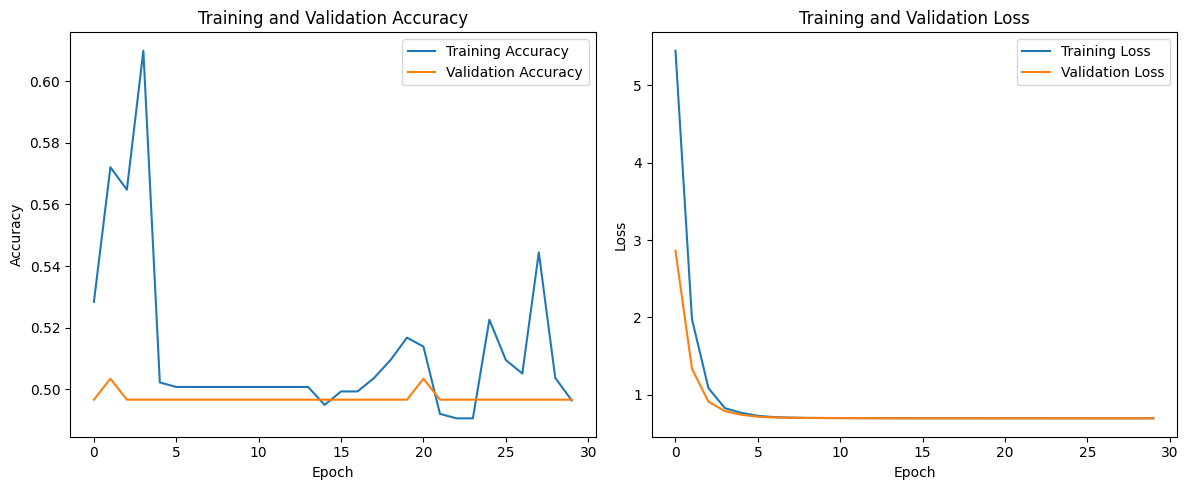

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model on the Test Set

In [33]:
# Evaluate the model on the test set
test_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\test"

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Found 148 images belonging to 2 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5252 - loss: 0.6931
Test Accuracy: 50.00%
Test Loss: 0.6932


## Visualize Misclassifications

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the test generator
test_generator.reset()  # Reset generator to start from the first batch
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Find misclassified examples
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Plot some misclassified examples
plt.figure(figsize=(12, 12))
for i, index in enumerate(misclassified_indices[:9]):  # Display up to 9 misclassified examples
    img_path = test_generator.filepaths[index]
    img = plt.imread(img_path)
    true_label = true_classes[index]
    pred_label = predicted_classes[index]
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]} | Pred: {class_labels[pred_label]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Using MobileNetV2 to improve performance and generalization 

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Paths to training, validation, and test sets
train_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\train"
val_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\val"
test_dir = r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\data_split\test"

# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base model layers to prevent training
base_model.trainable = False

# Build the transfer learning model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten for better performance
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

# Save the model
model.save(r"C:\Users\kalop\CV_Projects\HappyorSadPrediction\happy_sad_transfer_learning.keras")

print("Model training completed and saved!")


Found 687 images belonging to 2 classes.
Found 147 images belonging to 2 classes.
Found 148 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 405ms/step - accuracy: 0.5382 - loss: 0.9380 - val_accuracy: 0.7143 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.6353 - loss: 0.6298 - val_accuracy: 0.7347 - val_loss: 0.5653 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.7039 - loss: 0.5693 - val_accuracy: 0.7687 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.7071 - loss: 0.5718 - val_accuracy: 0.7347 - val_loss: 0.5404 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.6960 - loss: 0.5647 - val_accuracy: 0.7551 - val_loss: 0.5284 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.7

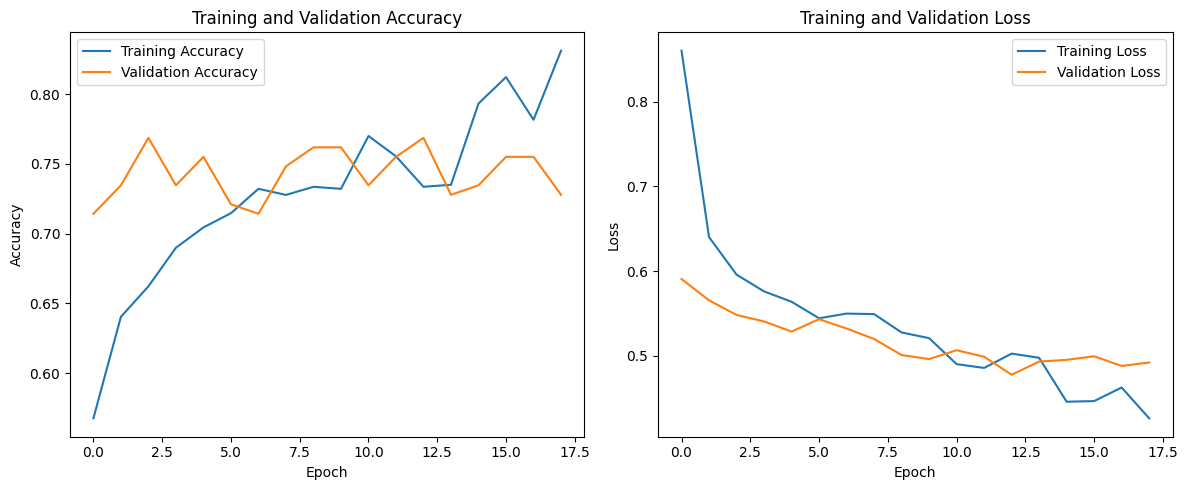

In [35]:
import matplotlib.pyplot as plt

# Visualize Training and Validation Accuracy/Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)

In [36]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7295 - loss: 0.5831
Test Accuracy: 70.27%
Test Loss: 0.5874


## Deploying in Streamlit

In [37]:
streamlit_code = """
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image

# Path to your saved model
MODEL_PATH = r"C:\\Users\\kalop\\CV_Projects\\HappyorSadPrediction\\happy_sad_model_vgg16.keras"

# Load the trained model
model = load_model(MODEL_PATH)

# Constants for image preprocessing
IMG_HEIGHT = 128
IMG_WIDTH = 128
CLASS_NAMES = ["Sad", "Happy"]

# Function to preprocess the uploaded image
def preprocess_image(image):
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))  # Resize to match model input
    image = img_to_array(image)  # Convert to array
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image / 255.0  # Normalize pixel values
    return image

# Streamlit UI
st.title("Happy or Sad Emotion Detector")
st.write("Upload an image, and the model will predict whether the emotion is Happy or Sad.")

# File uploader
uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Display the uploaded image
    st.image(uploaded_file, caption="Uploaded Image", use_column_width=True)

    # Process the image
    image = Image.open(uploaded_file).convert("RGB")  # Ensure image is in RGB format
    processed_image = preprocess_image(image)

    # Make prediction
    prediction = model.predict(processed_image)[0][0]
    predicted_class = CLASS_NAMES[int(prediction > 0.5)]
    confidence = prediction if predicted_class == "Happy" else 1 - prediction

    # Display the result
    st.write(f"Prediction: **{predicted_class}**")
    st.write(f"Confidence: **{confidence * 100:.2f}%**")
"""

# Save the Streamlit code to a file
with open("app.py", "w") as f:
    f.write(streamlit_code)

print("Streamlit app saved as 'app.py'.")


Streamlit app saved as 'app.py'.


In [ ]:
# Launch the Streamlit app
def launch_streamlit():
    app_path = os.path.join(os.getcwd(), "app.py")  # Ensure the app is saved in the current directory
    subprocess.run(["streamlit", "run", app_path], check=True)

# Launch the app
launch_streamlit()